This is model from the v3 split dataset

By the end of this file
1) ANN_T_label_encoder is saved in "../models/"
2) ANN_T_model.joblib is saved in "../models/"
3) ANN_T_model_history.joblib is saved in "../models/"
5) Classification report on the train_v3 prediction is saved in ".../data/external/" as 'df_clr_ANN_T_X_train_v3.csv'
6) Classification report on the test_v3 prediction is saved in ".../data/external/" as 'df_clr_ANN_T_X_test_v3.csv'
4) csv file with th original test_v3 df with prediction is saved in ".../data/external/" as 'df_X_test_v3_output.csv'

Custom functions used:
1) from ds.data.sets import load_sets_v2
2) from ds.models.performance import plot_model_learningcurve, plot_model_accuracy, plot_model_loss, df_classifcation_report

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# for Tina machine only, to import .py from src/ds/
import os
current_workpath = os.getcwd()
print("Current workpath:", current_workpath)

parent_folder = os.path.dirname(current_workpath)
print("Parent_folder:", parent_folder)

import sys
sys.path.append(parent_folder+'/src')
print(sys.path[-1])

Current workpath: /home/tina4aiml/dev/notebooks
Parent_folder: /home/tina4aiml/dev
/home/tina4aiml/dev/src


In [3]:
rawfile_name = 'beer_reviews'
rawfile_format = '.csv'
rawfile_path = "../data/raw/"

interim_folder_path = "../data/interim/"
processed_folder_path  ="../data/processed/"
external_folder_path  ="../data/external/"
model_folder_path = "../models/"

# import data

In [4]:
import pandas as pd
import numpy as np

In [5]:
from ds.data.sets import load_sets_v2

In [6]:
X_train_v3, y_train_v3, X_val_v3, y_val_v3, X_test_v3, y_test_v3 = load_sets_v2(path='../data/processed/', suffix='_v3')

X_train_v3 shape: (951968, 6)
y_train_v3 shape: (951968,)
X_val_v3 shape: (317323, 6)
y_val_v3 shape: (317323,)
X_test_v3 shape: (317323, 6)
y_test_v3 shape: (317323,)


In [7]:
# Check if the datasets were loaded successfully
if X_train_v3 is not None:
    print("X_train_v3 shape:", X_train_v3.shape) # (951968, 6)
else:
    print("X_train_v3 file not found")

if y_train_v3 is not None:
    print("y_train_v3 shape:", y_train_v3.shape) #(951968,)
else:
    print("y_train_v3 file not found") 

if X_val_v3 is not None:
    print("X_val_v3 shape:", X_val_v3.shape) # (317323, 6)
else:
    print("X_val_v3 file not found")

if y_val_v3 is not None:
    print("y_val_v3 shape:", y_val_v3.shape) # (317323,)
else:
    print("y_val_v3 file not found")

if X_test_v3 is not None:
    print("X_test_v3 shape:", X_test_v3.shape) # (317323, 6)
else:
    print("X_test_v3 file not found")

if y_test_v3 is not None:
    print("y_test_v3 shape:", y_test_v3.shape) # (317323,)
else:
    print("y_test_v3 file not found")

X_train_v3 shape: (951968, 6)
y_train_v3 shape: (951968,)
X_val_v3 shape: (317323, 6)
y_val_v3 shape: (317323,)
X_test_v3 shape: (317323, 6)
y_test_v3 shape: (317323,)


# Encode target

In [8]:
from sklearn.preprocessing import LabelEncoder
import joblib

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the LabelEncoder on the training set
label_encoder.fit(y_train_v3)

# Save the LabelEncoder
joblib.dump(label_encoder, model_folder_path+'ANN_T_label_encoder.joblib')

# Transform the target variables
y_train_v3_encoded = label_encoder.transform(y_train_v3).astype(int)
y_val_v3_encoded = label_encoder.transform(y_val_v3).astype(int)
y_test_v3_encoded = label_encoder.transform(y_test_v3).astype(int)

In [9]:
X_train_v3 = X_train_v3.astype(float)
X_val_v3 = X_val_v3.astype(float)
X_test_v3 = X_test_v3.astype(float)

In [10]:
#both need to be int
print(y_train_v3_encoded.dtype)
print(X_train_v3.dtype)

int64
float64


# Define Neural Network Architecture

In [11]:
features_names = np.load(processed_folder_path+'features_label.npy',allow_pickle=True)
features_names_n = len(features_names)
features_names_n 

6

In [12]:
target_class = np.load(processed_folder_path+'beer_style.npy',allow_pickle=True)
target_class_n = len(target_class)
target_class_n 

104

In [13]:
import tensorflow as tf
tf.keras.backend.clear_session()

2023-07-09 12:44:01.470694: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-09 12:44:01.583404: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
tf.keras.utils.set_random_seed(1)
num_classes = target_class_n
input_shape = (features_names_n,)


In [15]:
## callback that will decrease the learning rate by a factor of 0.2 if the model doesn't improve after 5 epochs
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0000001)

In [16]:
ANN_T_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=input_shape),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

ANN_T_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


2023-07-09 12:44:03.531789: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-09 12:44:03.554396: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-09 12:44:03.554745: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-09 12:44:03.561566: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-09 12:44:03.561971: I tensorflow/compile

In [17]:
n_epochs = 20
n_batchsize = 32
es_patience = 5
monitor_metric = 'val_loss'

ANN_T_history = ANN_T_model.fit(
                          X_train_v3, 
                          y_train_v3_encoded, 
                          epochs=n_epochs, 
                          batch_size=n_batchsize, 
                          validation_data=(X_val_v3, y_val_v3_encoded),    
                          callbacks=[        
                            EarlyStopping(
                            monitor=monitor_metric,
                            patience=es_patience,
                            restore_best_weights=True
                            ),
                            reduce_lr
                        ] )
#runtime = 

Epoch 1/20


2023-07-09 12:44:07.711669: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-09 12:44:07.734043: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f3b830d5660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-09 12:44:07.734119: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-07-09 12:44:07.741727: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-09 12:44:08.102606: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-09 12:44:08.224052: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifeti

29749/29749 [==============================] - 156s 5ms/step - loss: 3.4548 - accuracy: 0.1708 - val_loss: 3.3080 - val_accuracy: 0.1899 - lr: 0.0010
Epoch 2/20
29749/29749 [==============================] - 155s 5ms/step - loss: 3.2813 - accuracy: 0.1956 - val_loss: 3.2519 - val_accuracy: 0.2035 - lr: 0.0010
Epoch 3/20
29749/29749 [==============================] - 158s 5ms/step - loss: 3.2454 - accuracy: 0.2020 - val_loss: 3.2142 - val_accuracy: 0.2078 - lr: 0.0010
Epoch 4/20
29749/29749 [==============================] - 160s 5ms/step - loss: 3.2187 - accuracy: 0.2091 - val_loss: 3.2138 - val_accuracy: 0.2110 - lr: 0.0010
Epoch 5/20
29749/29749 [==============================] - 166s 6ms/step - loss: 3.1991 - accuracy: 0.2137 - val_loss: 3.1941 - val_accuracy: 0.2161 - lr: 0.0010
Epoch 6/20
29749/29749 [==============================] - 164s 6ms/step - loss: 3.1861 - accuracy: 0.2168 - val_loss: 3.1673 - val_accuracy: 0.2184 - lr: 0.0010
Epoch 7/20
29749/29749 [=====================

In [18]:
from joblib import dump
dump(ANN_T_model, model_folder_path+'ANN_T_model.joblib')

['../models/ANN_T_model.joblib']

In [19]:
dump(ANN_T_model.history, model_folder_path+'ANN_T_model_history.joblib')

['../models/ANN_T_model_history.joblib']

# Model Performance

In [20]:
ANN_T_model = joblib.load(model_folder_path+'ANN_T_model.joblib')

In [21]:
ANN_T_history = joblib.load(model_folder_path+'ANN_T_model_history.joblib')

In [22]:
# Model Summary after model.save
ANN_T_model._name = 'ANN_T_model'
ANN_T_model.summary()

Model: "ANN_T_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               896       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 104)               1768      
                                                                 
Total params: 13,528
Trainable params: 13,528
Non-trainable params: 0
_________________________________________________________________


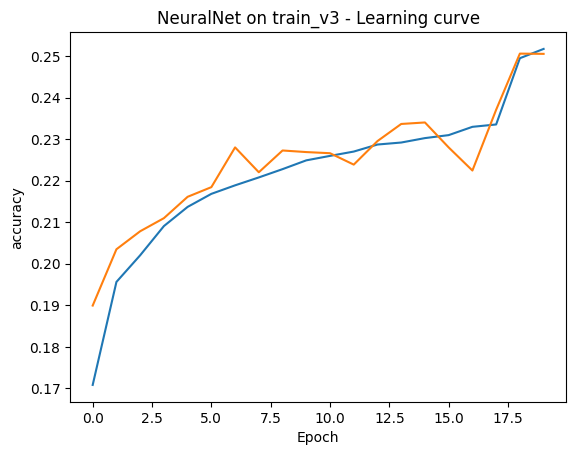

In [23]:
# Model- learning curve
from ds.models.performance import plot_model_learningcurve
plot_model_learningcurve(ANN_T_history.history,'NeuralNet on train_v3 - Learning curve')

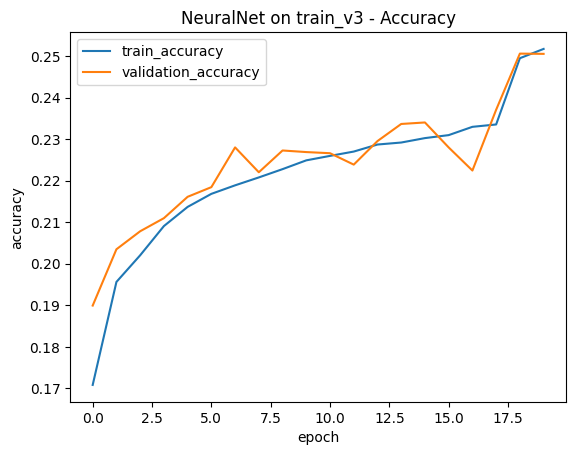

In [24]:
# plot performance on train set
from ds.models.performance import plot_model_accuracy, plot_model_loss

plot_model_accuracy(ANN_T_history.history,'NeuralNet on train_v3 - Accuracy')

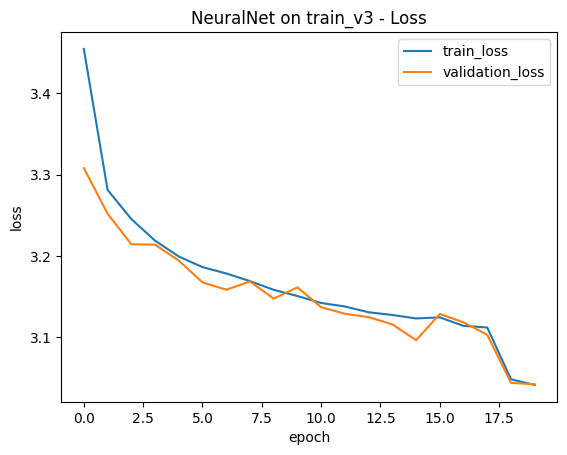

In [25]:
plot_model_loss(ANN_T_history.history,'NeuralNet on train_v3 - Loss')

In [26]:
# classification report
ANN_T_X_train_v3_predictions = np.argmax(ANN_T_model.predict(X_train_v3), axis=1)

29749/29749 [==============================] - 44s 1ms/step


In [27]:
#print overperformance metrics
from ds.models.performance import print_overall_model_metric
print_overall_model_metric(y_train_v3_encoded,ANN_T_X_train_v3_predictions, 'ANN_T_model','Trainset')
"""
Exp 1 - numeric impute by KNN columnwise, hidden layer = 2, epochs = 10
v3NN_model - Trainset Accuracy: 0.23646803253890888
v3NN_model - Trainset Precision: 0.27492554151748233
v3NN_model - Trainset Recall: 0.23646803253890888
v3NN_model - Trainset F1 Score: 0.1869457649785264

Exp 2 - numeric impute by mean, hidden layer = 2, epochs = 10
ANN_Tina_model - Trainset Accuracy: 0.2347904551413493
ANN_Tina_model - Trainset Precision: 0.256342174730209
ANN_Tina_model - Trainset Recall: 0.2347904551413493
ANN_Tina_model - Trainset F1 Score: 0.17865772444803876

Exp 3 - numeric impute by mean, hidden layer = 3, epochs = 20
ANN_T_model - Trainset Accuracy: 0.251167056035497
ANN_T_model - Trainset Precision: 0.27120038523333795
ANN_T_model - Trainset Recall: 0.251167056035497
ANN_T_model - Trainset F1 Score: 0.19564704703367253
"""

ANN_T_model - Trainset Accuracy: 0.25113239100473966
ANN_T_model - Trainset Precision: 0.2669663348656222
ANN_T_model - Trainset Recall: 0.25113239100473966
ANN_T_model - Trainset F1 Score: 0.19496783590371175


'\nExp 1 - numeric impute by KNN columnwise, hidden layer = 2, epochs = 10\nv3NN_model - Trainset Accuracy: 0.23646803253890888\nv3NN_model - Trainset Precision: 0.27492554151748233\nv3NN_model - Trainset Recall: 0.23646803253890888\nv3NN_model - Trainset F1 Score: 0.1869457649785264\n\nExp 2 - numeric impute by mean, hidden layer = 2, epochs = 10\nANN_Tina_model - Trainset Accuracy: 0.2347904551413493\nANN_Tina_model - Trainset Precision: 0.256342174730209\nANN_Tina_model - Trainset Recall: 0.2347904551413493\nANN_Tina_model - Trainset F1 Score: 0.17865772444803876\n\nExp 3 - numeric impute by mean, hidden layer = 3, epochs = 20\nANN_T_model - Trainset Accuracy: 0.251167056035497\nANN_T_model - Trainset Precision: 0.27120038523333795\nANN_T_model - Trainset Recall: 0.251167056035497\nANN_T_model - Trainset F1 Score: 0.19564704703367253\n'

In [28]:
#features_names = np.load(processed_folder_path+'features_label.npy',allow_pickle=True)
#target_class = np.load(processed_folder_path+'beer_style.npy',allow_pickle=True)

In [29]:
from ds.models.performance import df_classifcation_report
df_classifcation_report(
    y_encoded = y_train_v3_encoded, 
    y_prediction = ANN_T_X_train_v3_predictions, 
    target_names = target_class,
    filename = 'df_clr_ANN_T_X_train_v3.csv', 
    dest = external_folder_path
    )

                                                    Precision  Recall  \
Class                                                                   
support\n\n                         Hefeweizen ...       0.00    0.00   
English Strong Ale                                       0.24    0.73   
Foreign / Export Stout                                   0.23    0.06   
German Pilsener                                          0.32    0.17   
American Double / Imperial IPA                           0.23    0.30   
...                                                       ...     ...   
Happoshu                                                 0.00    0.00   
Sahti                                                    0.17    0.05   
Bière de Champagne / Bière Brut                          0.11    0.15   
951968\n                          macro avg              0.23    0.13   
weighted avg                                             0.27    0.25   

                                                  

# 2) Get Accuracy on test_set

In [30]:
y_test_v3_pred_probs = ANN_T_model.predict(X_test_v3)
y_test_v3_pred = y_test_v3_pred_probs.argmax(axis=1)
y_test_v3_pred

9917/9917 [==============================] - 15s 2ms/step


array([ 9, 89, 14, ..., 12, 12, 98])

In [31]:
from sklearn.metrics import accuracy_score
ANN_T_model_test_accuracy = accuracy_score(y_test_v3_encoded, y_test_v3_pred)

In [32]:
print(f"Test Set Accuracy: {ANN_T_model_test_accuracy} or {ANN_T_model_test_accuracy:.2%}")

Test Set Accuracy: 0.2486803666926129 or 24.87%


In [33]:
print_overall_model_metric(y_test_v3_encoded, y_test_v3_pred, 'ANN_T_model','Testset')
"""
Exp 1 - numeric impute by KNN columnwise
v3NN_model - Testset Accuracy: 0.23450868673244613
v3NN_model - Testset Precision: 0.27564628804585606
v3NN_model - Testset Recall: 0.23450868673244613
v3NN_model - Testset F1 Score: 0.18510128840197598

Exp 2 - numeric impute by mean
ANN_Tina_model - Testset Accuracy: 0.23299603243382924
ANN_Tina_model - Testset Precision: 0.25523461092186067
ANN_Tina_model - Testset Recall: 0.23299603243382924
ANN_Tina_model - Testset F1 Score: 0.1771727300559152

Exp 3 - numeric impute by mean, hidden layer = 3, epochs = 20
ANN_T_model - Testset Accuracy: 0.24925076341771632
ANN_T_model - Testset Precision: 0.27169378111302694
ANN_T_model - Testset Recall: 0.24925076341771632
ANN_T_model - Testset F1 Score: 0.19433751690507442
"""

ANN_T_model - Testset Accuracy: 0.2486803666926129
ANN_T_model - Testset Precision: 0.26567566942379073
ANN_T_model - Testset Recall: 0.2486803666926129
ANN_T_model - Testset F1 Score: 0.19298067838359176


'\nExp 1 - numeric impute by KNN columnwise\nv3NN_model - Testset Accuracy: 0.23450868673244613\nv3NN_model - Testset Precision: 0.27564628804585606\nv3NN_model - Testset Recall: 0.23450868673244613\nv3NN_model - Testset F1 Score: 0.18510128840197598\n\nExp 2 - numeric impute by mean\nANN_Tina_model - Testset Accuracy: 0.23299603243382924\nANN_Tina_model - Testset Precision: 0.25523461092186067\nANN_Tina_model - Testset Recall: 0.23299603243382924\nANN_Tina_model - Testset F1 Score: 0.1771727300559152\n\nExp 3 - numeric impute by mean, hidden layer = 3, epochs = 20\nANN_T_model - Testset Accuracy: 0.24925076341771632\nANN_T_model - Testset Precision: 0.27169378111302694\nANN_T_model - Testset Recall: 0.24925076341771632\nANN_T_model - Testset F1 Score: 0.19433751690507442\n'

In [34]:
# Classification report
df_classifcation_report(
    y_encoded = y_test_v3_encoded, 
    y_prediction = y_test_v3_pred, 
    target_names = target_class,
    filename = 'df_clr_ANN_T_X_test_v3.csv', 
    dest = external_folder_path
    )

                                                    Precision  Recall  \
Class                                                                   
support\n\n                         Hefeweizen ...       0.00    0.00   
English Strong Ale                                       0.24    0.73   
Foreign / Export Stout                                   0.22    0.06   
German Pilsener                                          0.31    0.18   
American Double / Imperial IPA                           0.24    0.31   
...                                                       ...     ...   
Happoshu                                                 0.00    0.00   
Sahti                                                    0.16    0.05   
Bière de Champagne / Bière Brut                          0.10    0.15   
317323\n                          macro avg              0.23    0.13   
weighted avg                                             0.27    0.25   

                                                  

In [35]:
# Load the saved LabelEncoder
label_encoder = joblib.load(model_folder_path+'ANN_T_label_encoder.joblib')

# Revert the encoded labels back to their original text form
y_test_v3_pred_decoded = label_encoder.inverse_transform(y_test_v3_pred)
y_test_v3_pred_decoded

array(['American Double / Imperial IPA', 'Russian Imperial Stout',
       'American Pale Ale (APA)', ..., 'American IPA', 'American IPA',
       'Tripel'], dtype=object)

# Assemble back to df

In [36]:
df_X_test_v3_unencoded = pd.read_pickle(interim_folder_path + 'df_X_test_v3_unencoded.pkl')
df_X_test_v3_unencoded['prediction'] = y_test_v3_pred_decoded
df_X_test_v3_unencoded.to_csv(external_folder_path+'df_X_test_v3_output.csv', index=True)